In [1]:
import emcee
import numpy as np

import corner
from matplotlib import pyplot as plt
from scipy import optimize

from cr_knee_fit.inference import (
    initial_guess_model,
    make_loglikelihood,
    make_logposterior,
)
from cr_knee_fit.model import Model, ModelConfig
from cr_knee_fit.types_ import Experiment, Primary
from cr_knee_fit.fit_data import FitData

In [2]:
# PRIMARIES = [Primary.H, Primary.He, Primary.C, Primary.O]
# EXPERIMENTS = [Experiment.AMS02, Experiment.DAMPE, Experiment.CALET, Experiment.CREAM]
PRIMARIES = [Primary.H, Primary.He]
EXPERIMENTS = [Experiment.AMS02, Experiment.DAMPE, Experiment.GRAPES]

R_BOUNDS = (7e2, 1e8)  # GV

In [11]:
from cr_knee_fit.cr_model import CosmicRaysModelConfig


fit_data = FitData.load(EXPERIMENTS, PRIMARIES, R_BOUNDS)
config = ModelConfig(
    cr_model_config=CosmicRaysModelConfig(
        primaries=PRIMARIES,
        n_breaks=2,
    ),
    shifted_experiments=[e for e in EXPERIMENTS if e is not Experiment.AMS02],
)

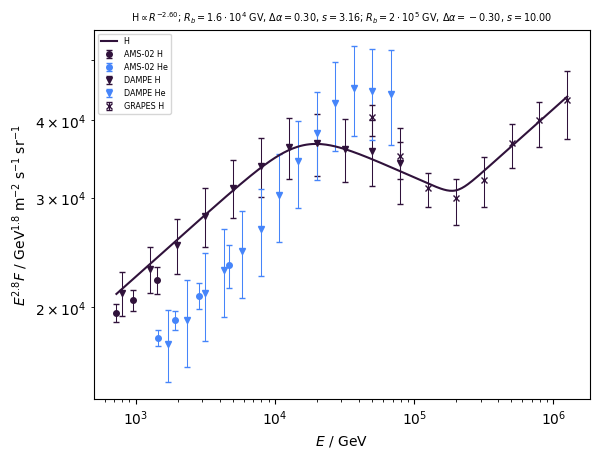

In [12]:
from cr_knee_fit.cr_model import CosmicRaysModel, PowerLaw, RigidityBreak
from cr_knee_fit.shifts import ExperimentEnergyScaleShifts


Model(
    cr_model=CosmicRaysModel(
        components={Primary.H: PowerLaw(lgI=-4.05, alpha=2.6)},
        breaks=[
            RigidityBreak(lg_R=4.2, d_alpha=0.3, lg_sharpness=0.5),
            RigidityBreak(lg_R=5.3, d_alpha=-0.3, lg_sharpness=1),
        ],
    ),
    energy_shifts=ExperimentEnergyScaleShifts({}),
).plot(fit_data, scale=2.8);

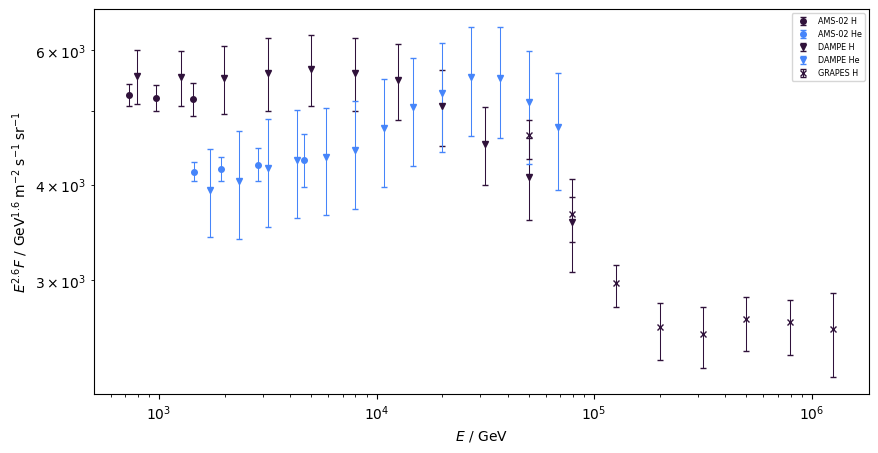

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

for _, p_data in fit_data.spectra.items():
    for _, data in p_data.items():
        data.plot(scale=2.6, ax=ax)

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")

## Pre-optimization


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.847310318346883
             x: [-4.078e+00  2.585e+00 -4.959e+00  2.522e+00  4.467e+00
                  4.337e-01  4.910e-01  5.248e+00 -4.168e-01  1.253e+00]
           nit: 1073
          nfev: 1559
 final_simplex: (array([[-4.078e+00,  2.585e+00, ..., -4.168e-01,
                         1.253e+00],
                       [-4.078e+00,  2.585e+00, ..., -4.168e-01,
                         1.254e+00],
                       ...,
                       [-4.078e+00,  2.585e+00, ..., -4.168e-01,
                         1.253e+00],
                       [-4.078e+00,  2.585e+00, ..., -4.168e-01,
                         1.253e+00]]), array([ 2.847e+00,  2.847e+00,  2.847e+00,  2.847e+00,
                        2.847e+00,  2.847e+00,  2.847e+00,  2.847e+00,
                        2.847e+00,  2.847e+00,  2.847e+00]))
lg(I) (H) = -4.08e+00
alpha (H) = 2.59e+00
lg(I) (He) = -4.9

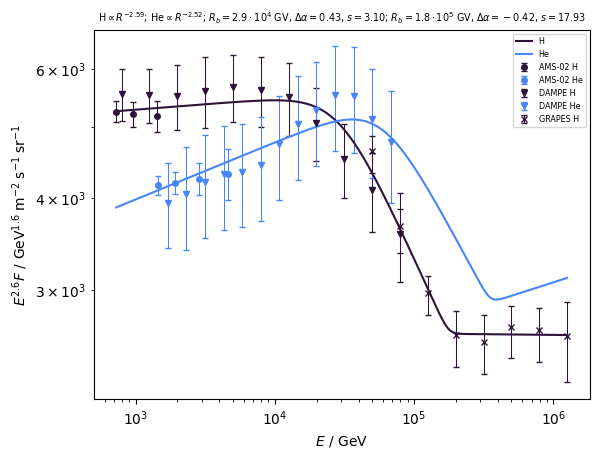

In [17]:
import dataclasses


pre_optimization_config = dataclasses.replace(config, shifted_experiments={})
loglike = make_loglikelihood(fit_data, pre_optimization_config)


def minimized_fn(v: np.ndarray) -> float:
    return -loglike(v)


res = optimize.minimize(
    minimized_fn,
    x0=initial_guess_model(pre_optimization_config),
    method="Nelder-Mead",
    options={
        "maxiter": 100_000,
    },
)
print(res)

mle_model = Model.unpack(res.x, layout_info=pre_optimization_config)
mle_model.plot(fit_data, scale=2.6)
print(mle_model.format_params())

In [24]:
init_model = initial_guess_model(config)

In [21]:
n_steps = 10_000
n_walkers = 128
n_dim = init_model.ndim()

sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=make_logposterior(fit_data, config),
)
initial_state = np.array([initial_guess_model(config).pack() for _ in range(n_walkers)])
sampler.run_mcmc(initial_state, nsteps=n_steps, progress=True)
print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

tau = sampler.get_autocorr_time(quiet=True)
print(f"{tau = }")

burn_in = 5 * int(tau.max())
thin = 2 * int(tau.max())

print(f"{burn_in = } {thin = }")

theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)  # type: ignore
print(f"MCMC sample ready, shape: {theta_sample.shape}")

100%|██████████| 10000/10000 [06:04<00:00, 27.46it/s]


Acceptance fraction: 0.3074984375


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [114.72726351 224.2434623  107.11687689 180.69268505 401.96178311
 490.99953559 192.56159546 367.64199613 460.92930068 193.97491134
 176.59067196 182.59599619]


tau = array([114.72726351, 224.2434623 , 107.11687689, 180.69268505,
       401.96178311, 490.99953559, 192.56159546, 367.64199613,
       460.92930068, 193.97491134, 176.59067196, 182.59599619])
burn_in = 2450 thin = 980
MCMC sample ready, shape: (896, 12)


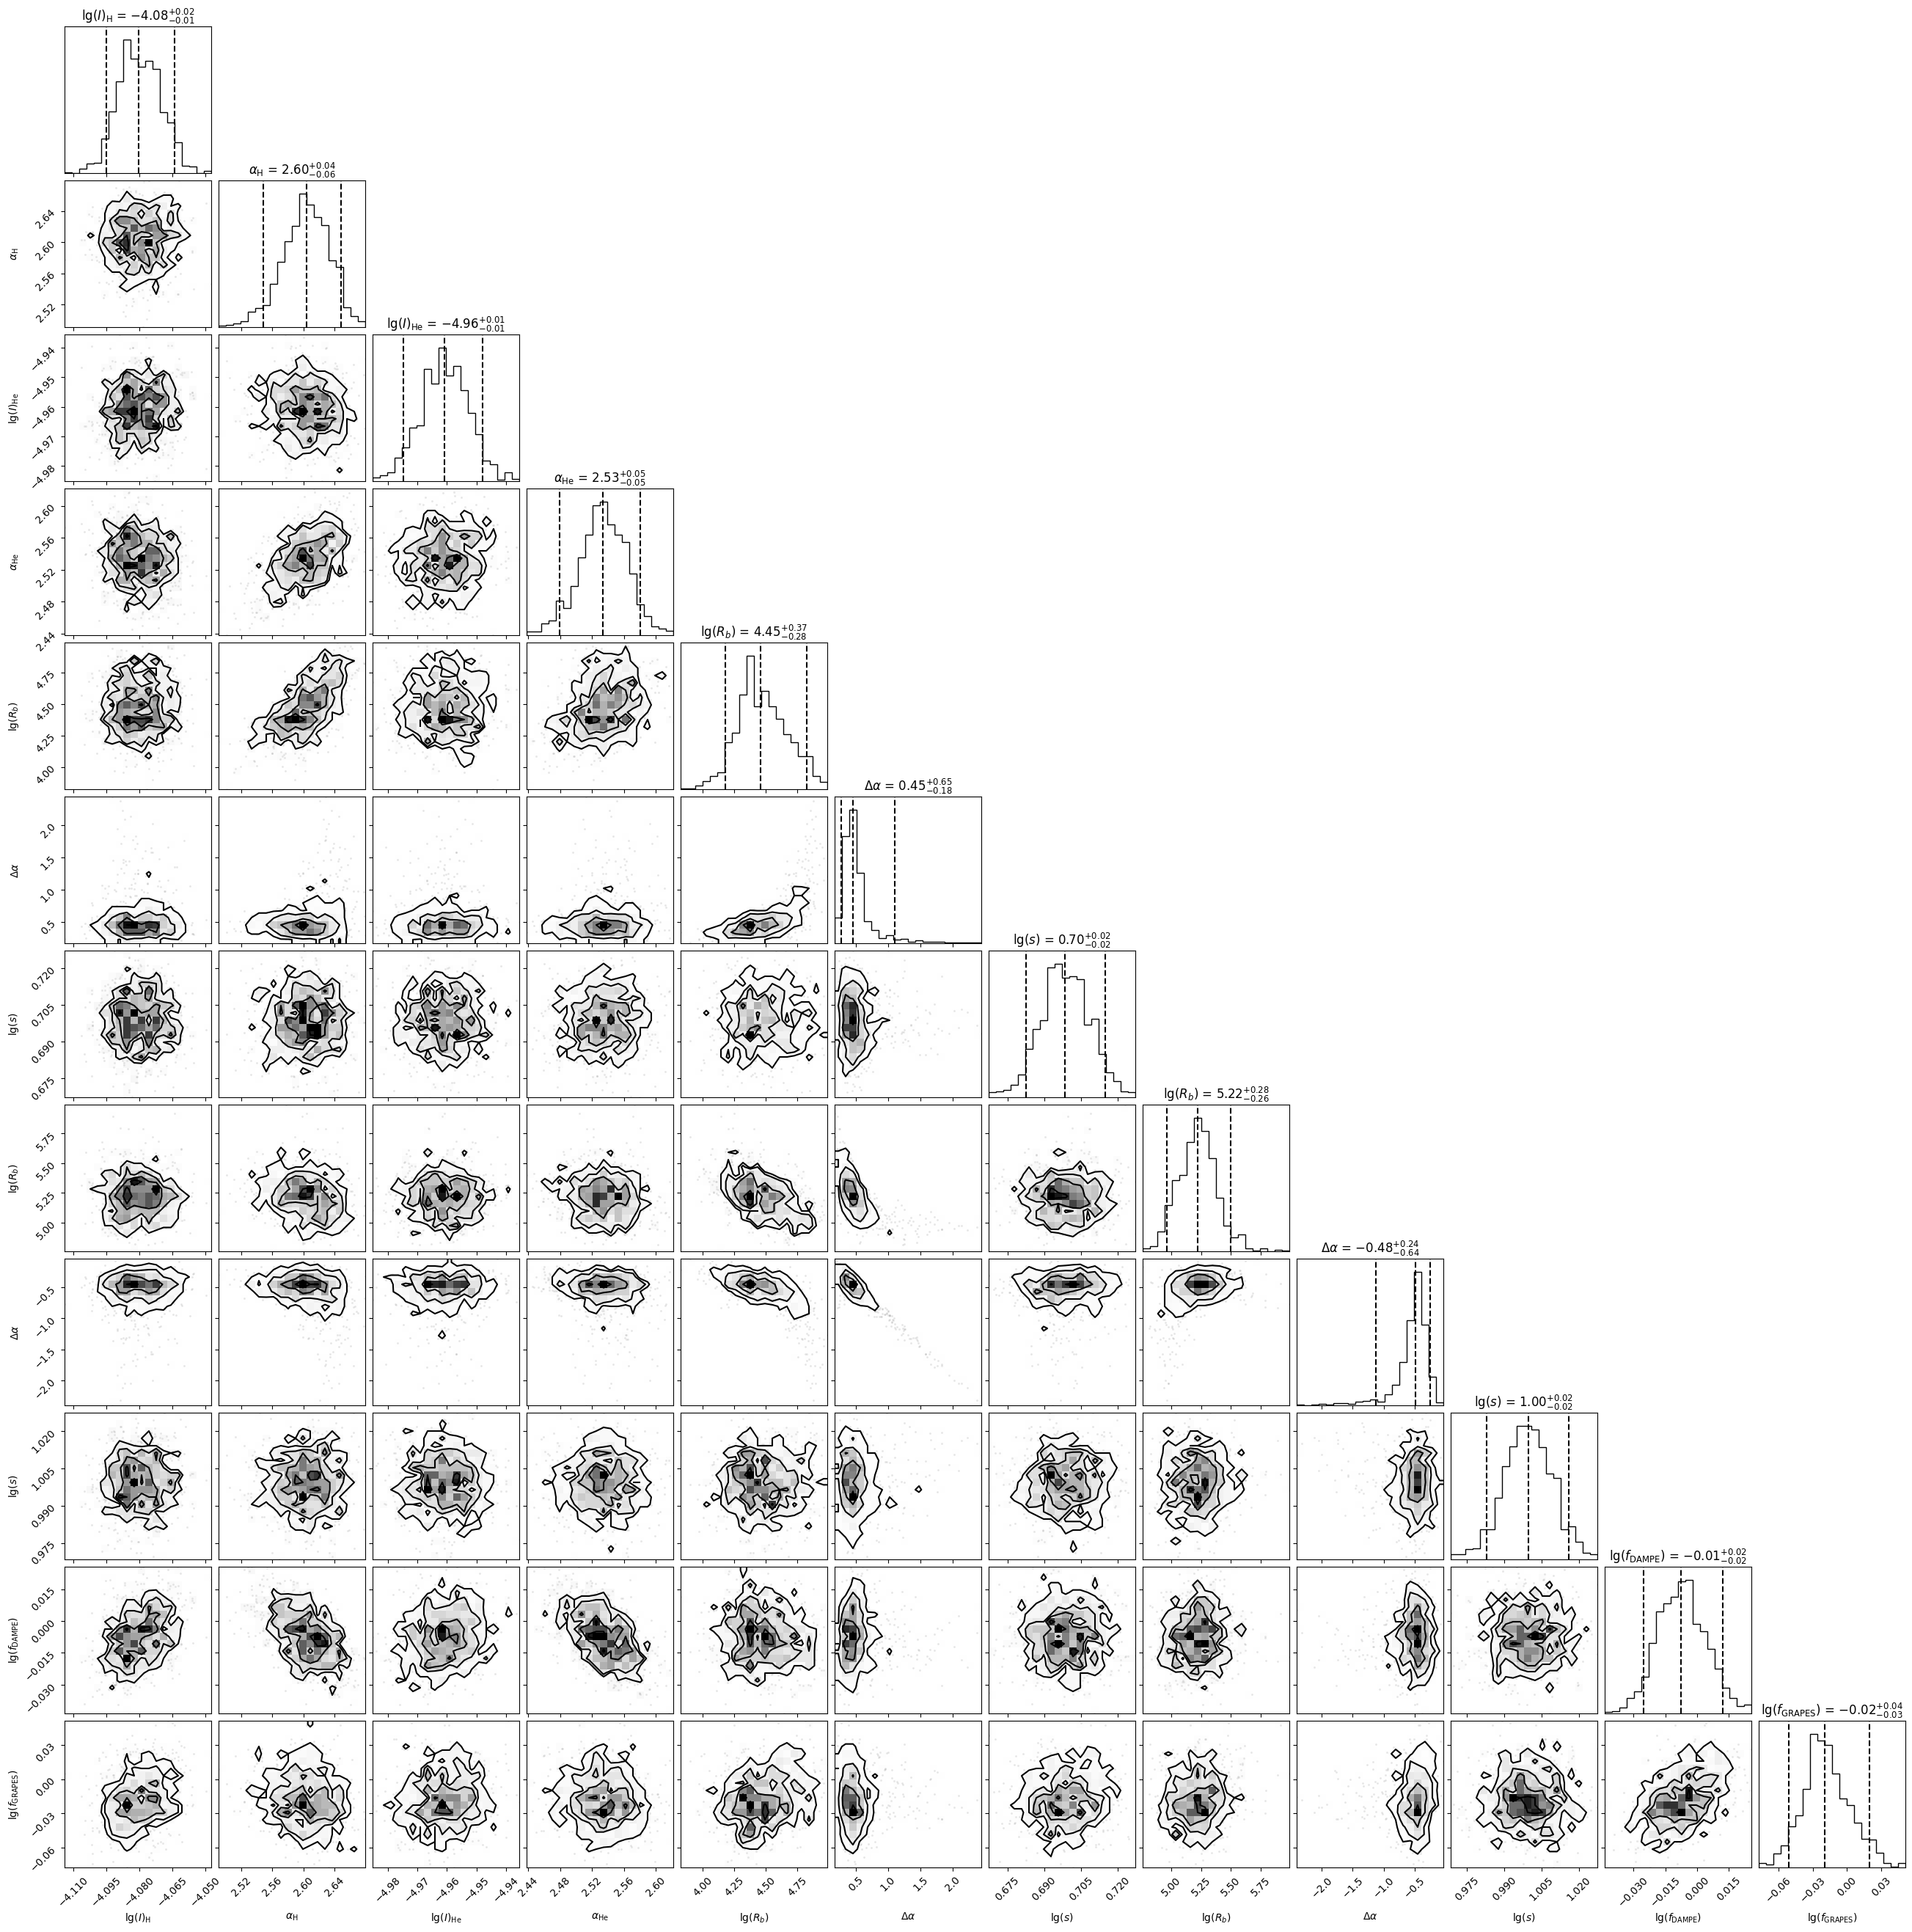

In [25]:

sample_to_plot = theta_sample
sample_labels = ["$" + label + "$" for label in init_model.labels(True)]

_ = corner.corner(
    sample_to_plot,
    labels=sample_labels,
    show_titles=True,
    quantiles=[0.05, 0.5, 0.95],
)

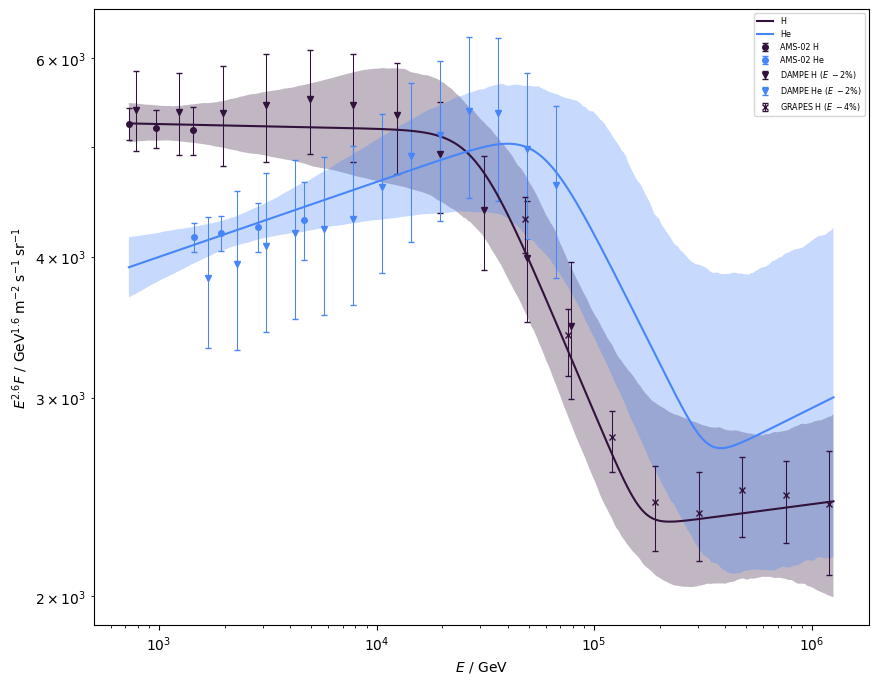

In [27]:
scale = 2.6
model_sample = [Model.unpack(theta, layout_info=config) for theta in theta_sample]
median_model = Model.unpack(np.median(theta_sample, axis=0), layout_info=config)

fig, ax = plt.subplots(figsize=(10, 8))

for exp, data_by_particle in fit_data.spectra.items():
    for _, data in data_by_particle.items():
        data.with_shifted_energy_scale(f=median_model.energy_shifts.f(exp)).plot(scale=scale, ax=ax)

primaries = list(median_model.cr_model.components.keys())
Emin, Emax = fit_data.model_E_range()
median_model.cr_model.plot(Emin, Emax, scale=scale, axes=ax)

E_grid = np.logspace(np.log10(Emin), np.log10(Emax), 300)
E_factor = E_grid**scale
for p in primaries:
    upper = []
    lower = []
    for E in E_grid:
        predictions = np.array([model.cr_model.compute(E, p) for model in model_sample])
        lower.append(np.quantile(predictions, q=0.05))
        upper.append(np.quantile(predictions, q=0.95))
    ax.fill_between(
        E_grid,
        E_factor * lower,
        E_factor * upper,
        color=p.color,
        alpha=0.3,
        edgecolor="none",
    )

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(bottom=1e3)